# Predicción de géneros musicales
## Miguel Bande, Octavian Rotita

In [84]:
# En primer lugar importamos las librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
import plotly.express as px
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import PIL.Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.utils import resample

# Cargamos el dataset:

Hemos cogido el codigo de https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset. Hemos cogido el dataset y lo hemos subido a github para que no se cambie el dataset cada vez que lo corramos.

In [23]:
df = pd.read_csv('./dataset.csv')
df.head(20)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,...,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,...,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,...,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,...,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,...,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


| Feature           | Description (English)                                                                                                                                                                                                                                                                                                           | Descripción (Español)                                                                                                                                                                                                                                                                                                                                                        |
|-------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| track_id          | The Spotify ID for the track                                                                                                                                                                                                                                                                                                     | El ID de Spotify de la pista                                                                                                                                                                                                                                                                                                                                                  |
| artists           | The artists' names who performed the track. If there is more than one artist, they are separated by a “;”                                                                                                                                                                                                                         | Los nombres de los artistas que interpretan la pista. Si hay más de un artista, se separan con “;”.                                                                                                                                                                                                                                                                           |
| album_name        | The album name in which the track appears                                                                                                                                                                                                                                                                                         | El nombre del álbum en el que aparece la pista                                                                                                                                                                                                                                                                                                                                |
| track_name        | Name of the track                                                                                                                                                                                                                                                                                                               | El nombre de la pista                                                                                                                                                                                                                                                                                                                                                         |
| popularity        | The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. | La popularidad de una pista es un valor entre 0 y 100, donde 100 es la más popular. La popularidad se calcula mediante un algoritmo que se basa, principalmente, en el número total de reproducciones que ha tenido la pista y cuán recientes sean dichas reproducciones. En términos generales, las canciones que se reproducen mucho ahora tendrán mayor popularidad que las que se reprodujeron mucho en el pasado. Las pistas duplicadas (por ejemplo, la misma canción en un sencillo y en un álbum) se califican de forma independiente. La popularidad de un artista o álbum se deriva matemáticamente de la popularidad de sus pistas. |
| duration_ms       | The track length in milliseconds                                                                                                                                                                                                                                                                                                 | La duración de la pista en milisegundos                                                                                                                                                                                                                                                                                                                                       |
| explicit          | Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)                                                                                                                                                                                                                             | Indica si la pista contiene letras explícitas (true = sí, false = no o desconocido)                                                                                                                                                                                                                                                                                           |
| danceability      | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable                                                                                       | La bailabilidad describe cuán adecuada es una pista para bailar, basándose en una combinación de elementos musicales como el tempo, la estabilidad del ritmo, la fuerza del compás y la regularidad general. Un valor de 0.0 corresponde a la menor aptitud para bailar y 1.0 a la mayor.                                                                                   |
| energy            | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale                                                                                 | La energía es una medida que va de 0.0 a 1.0 y representa un valor perceptivo de intensidad y actividad. Por lo general, las pistas enérgicas se perciben como rápidas, potentes y estridentes. Por ejemplo, el death metal tiene una alta energía, mientras que un preludio de Bach puntúa bajo en la escala.                                                                  |
| key               | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1                                                                                                                                                            | La tonalidad en la que se encuentra la pista. Los números enteros se corresponden con notas utilizando la notación estándar de clase de tono (Pitch Class). Por ejemplo, 0 = Do, 1 = Do♯/Re♭, 2 = Re, etc. Si no se detecta tonalidad, el valor es -1.                                                                                   |
| loudness          | The overall loudness of a track in decibels (dB)                                                                                                                                                                                                                                                                                 | El nivel de volumen general de una pista en decibelios (dB)                                                                                                                                                                                                                                                                                                                  |
| mode              | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0                                                                                                                                                                   | El modo indica la modalidad (mayor o menor) de la pista, es decir, el tipo de escala de la que se deriva su contenido melódico. Mayor se representa con 1 y menor con 0.                                                                                                                                                                                                     |
| speechiness       | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks | Speechiness detecta la presencia de palabras habladas en una pista. Cuanto más se acerque a 1.0, más se asemeja a una grabación de solo discurso (por ejemplo, un programa de radio, un audiolibro o poesía). Valores por encima de 0.66 describen pistas que probablemente consisten enteramente en palabras habladas. Valores entre 0.33 y 0.66 describen pistas que pueden contener tanto música como discurso (por ejemplo, música rap). Valores por debajo de 0.33 representan con mayor probabilidad música y otras grabaciones sin carácter hablado. |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic                                                                                                                                                                                                      | Una medida de confianza que va de 0.0 a 1.0 para determinar si la pista es acústica. 1.0 indica alta confianza de que la pista sea acústica                                                                                                                                                                                                                                  |
| instrumentalness  | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content                                                         | Predice si una pista no contiene voces. Los sonidos como "ooh" y "aah" se tratan como instrumentales en este contexto. Las pistas de rap o de palabra hablada se consideran claramente "vocales". Cuanto más se acerque el valor de instrumentalness a 1.0, mayor es la probabilidad de que la pista no contenga voces.                                                        |
| liveness          | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live                                                                                                            | Detecta la presencia música en vivo en la grabación. Valores más altos de liveness indican una mayor probabilidad de que la pista haya sido interpretada en vivo. Un valor por encima de 0.8 sugiere con fuerza que la pista es una grabación en directo.                                                                                                                     |
| valence           | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)                                                                                | Una medida de 0.0 a 1.0 que describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más alegres (por ejemplo, felices, animadas, eufóricas), mientras que las pistas con valencia baja suenan más negativas (por ejemplo, tristes, melancólicas, enojadas).                                                                              |
| tempo             | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration                                                                                                                                        | El tempo estimado general de una pista en beats por minuto (BPM). En la terminología musical, el tempo es la velocidad o el pulso de una pieza y se deriva directamente de la duración promedio de cada pulso.                                                                                                                                                                 |
| time_signature    | An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.                                                                                                     | Un compás estimado. El compás (o métrica) es una convención notacional que especifica cuántos pulsos hay en cada compás. El valor puede variar de 3 a 7, representando compases de 3/4 hasta 7/4.                                                                                                                                                                           |
| track_genre       | The genre in which the track belongs                                                                                                                                                                                                                                                                                             | El género al que pertenece la pista                                                                                                                                                                                                                                                                                                                                             |


# Exploración datos

In [24]:
# Dimensión del dataset
Shape = df.shape
print(f'Las entradas del dataset son: {Shape[0]} y las variables son: {Shape[1]}\n')

# Primeras filas
#print(df.head())

# Información básica (tipos de datos y valores nulos)
print(df.info())

# Descripción estadística de las variables numéricas
#print(df.describe())


Las entradas del dataset son: 114000 y las variables son: 21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instru

In [25]:
numeric_features = df.select_dtypes(include=[np.number, bool]) 
# añadimos en numeric_features la columna 'track_id'


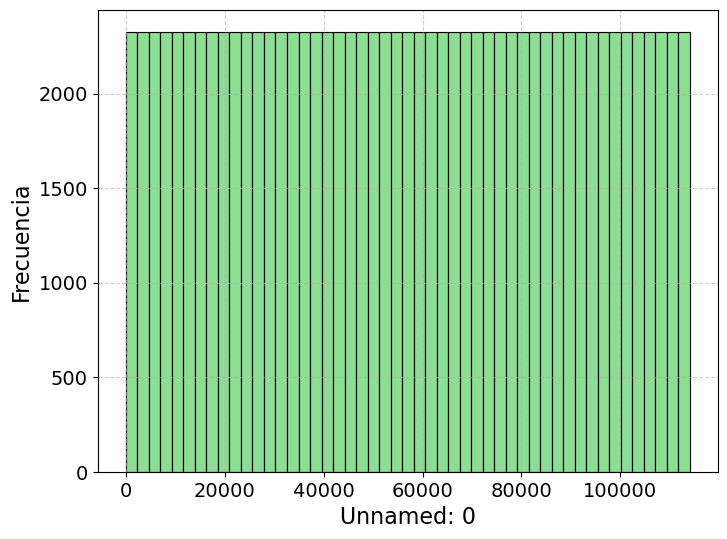

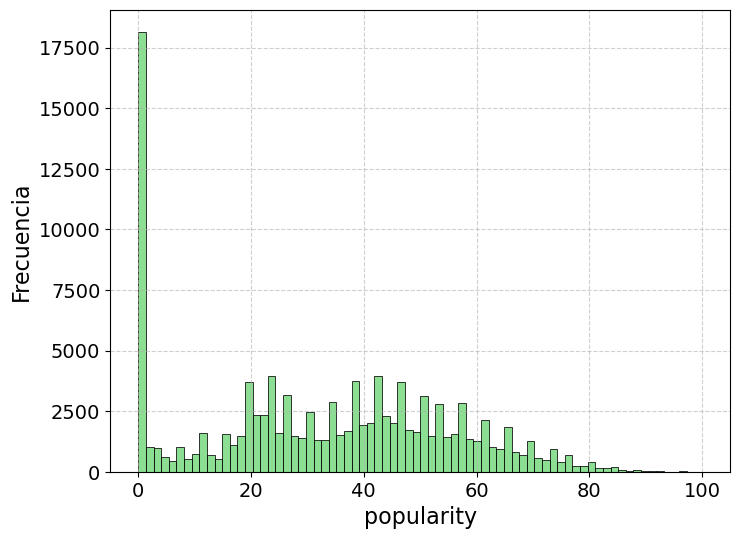

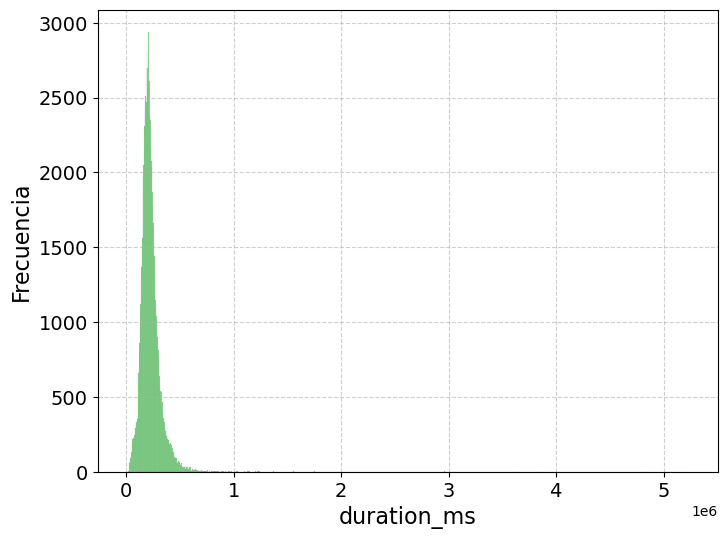

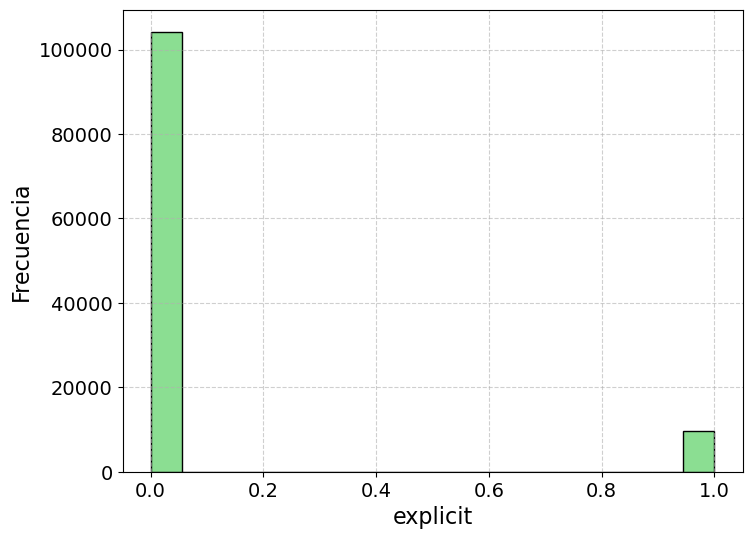

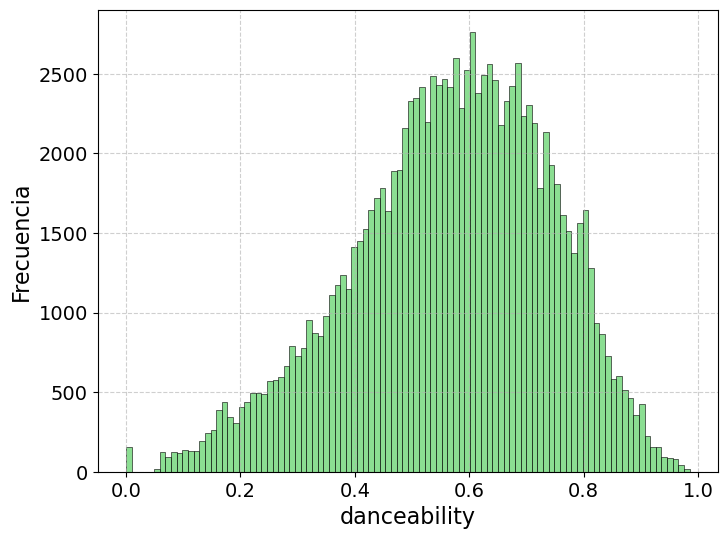

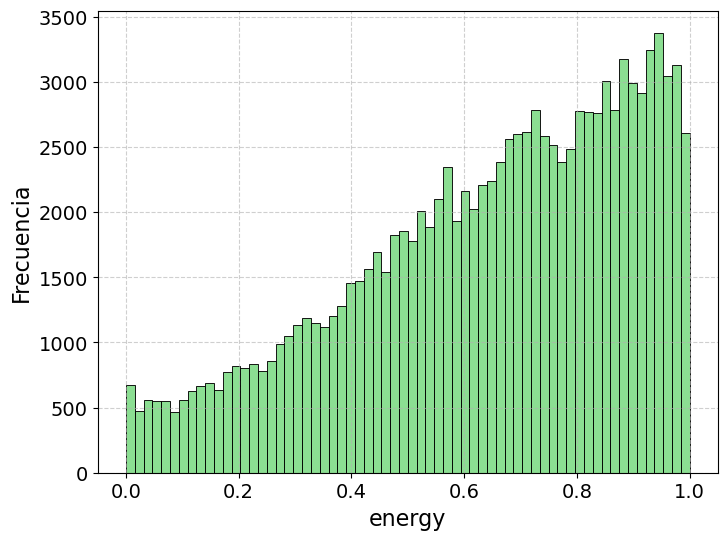

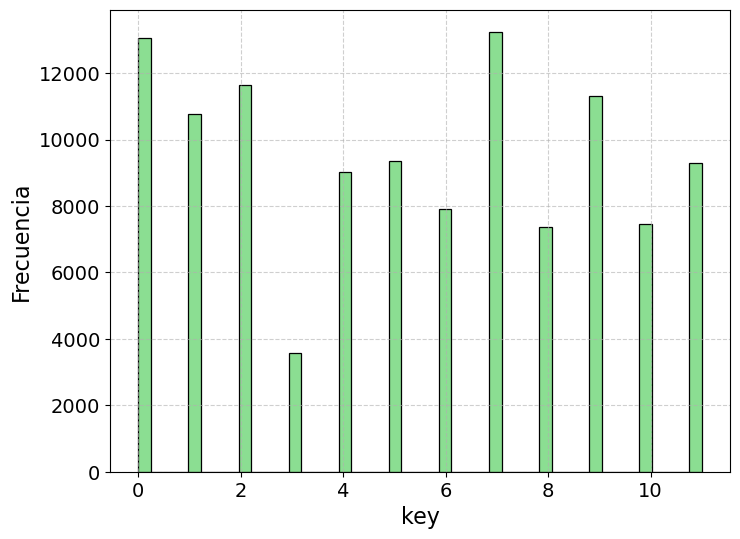

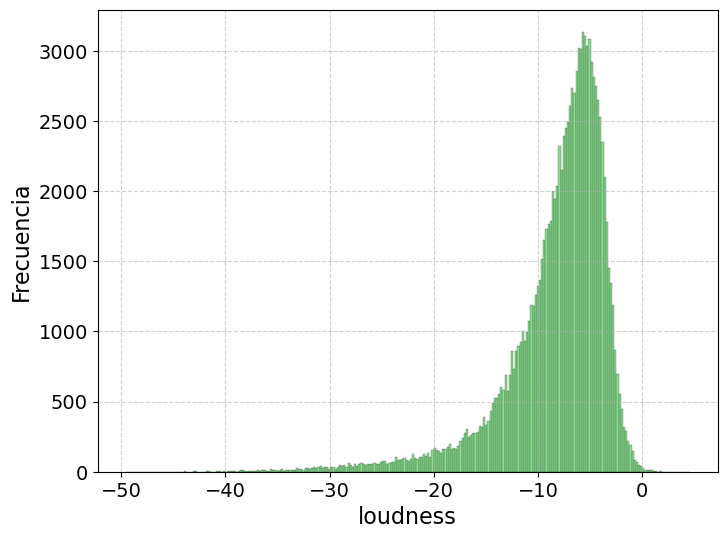

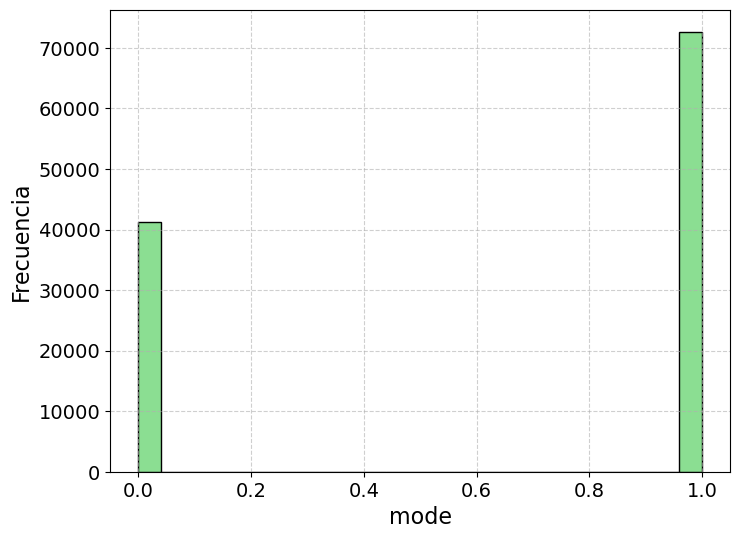

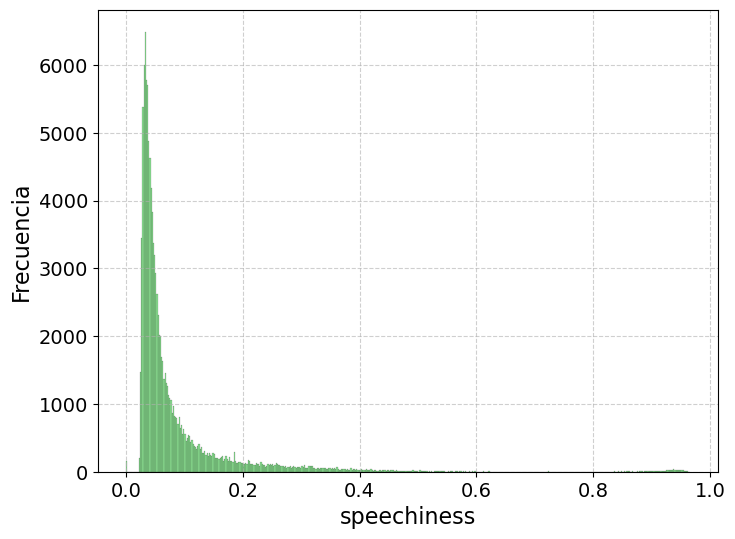

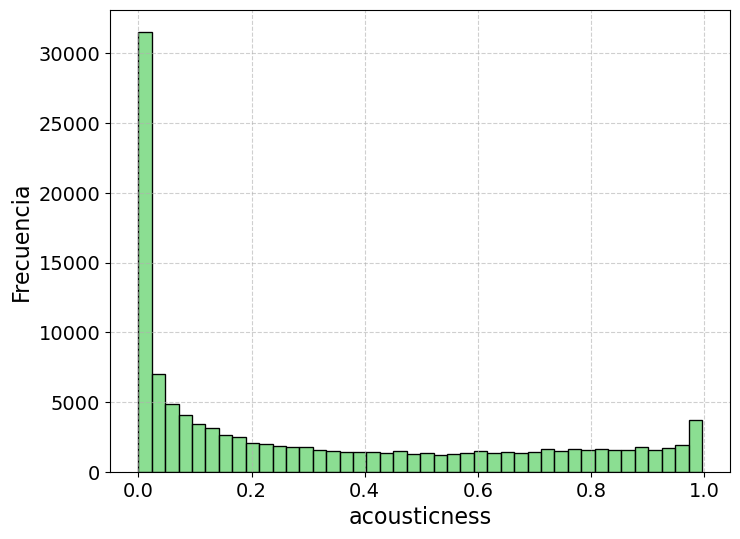

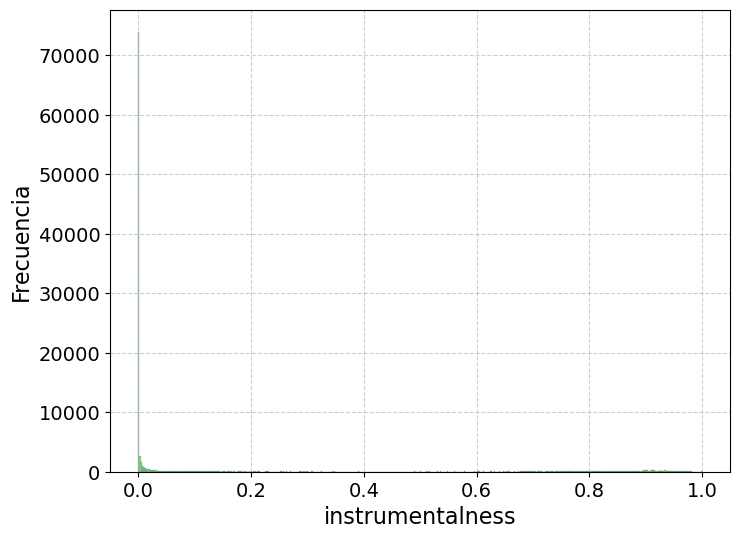

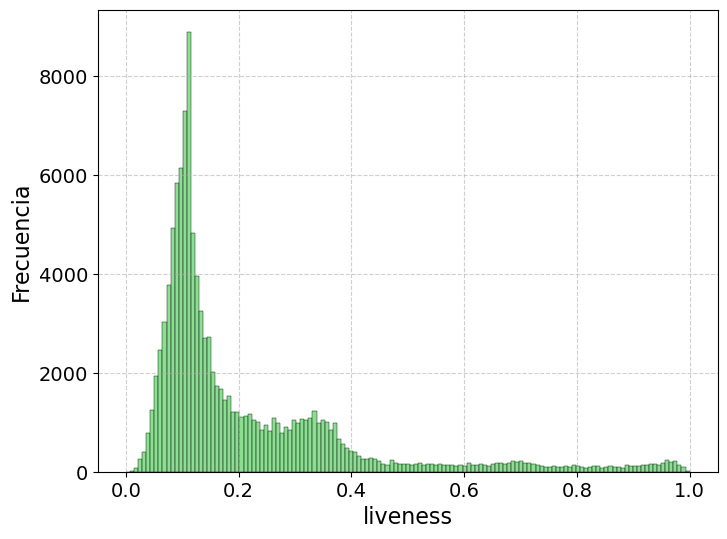

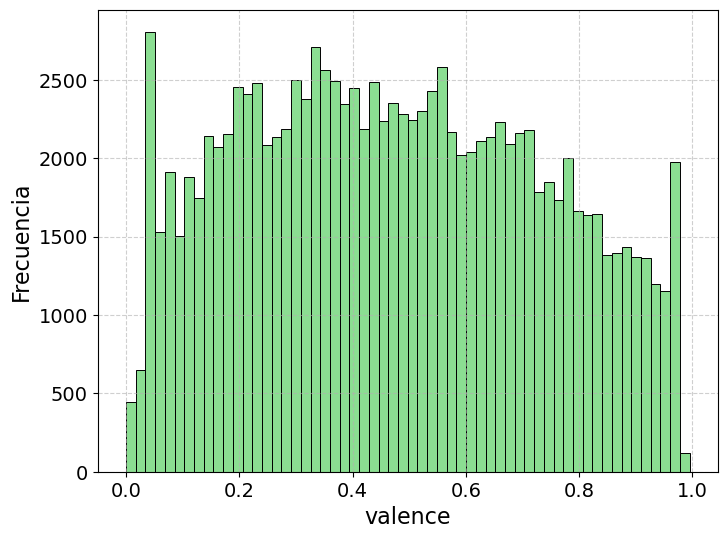

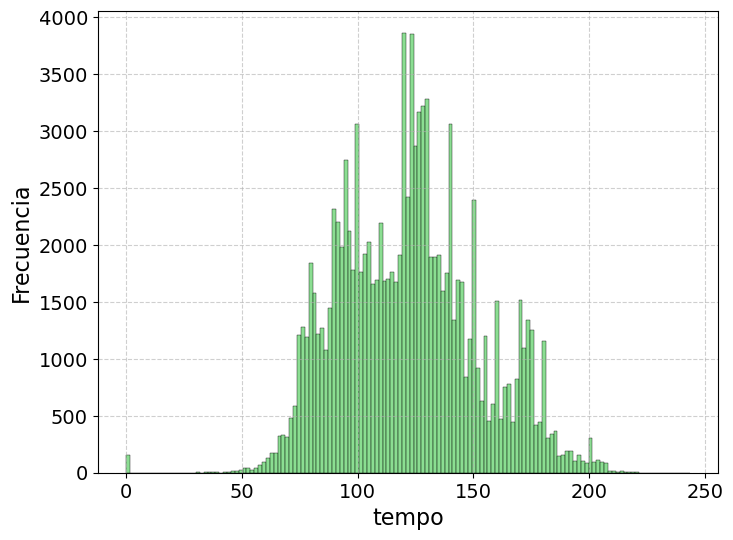

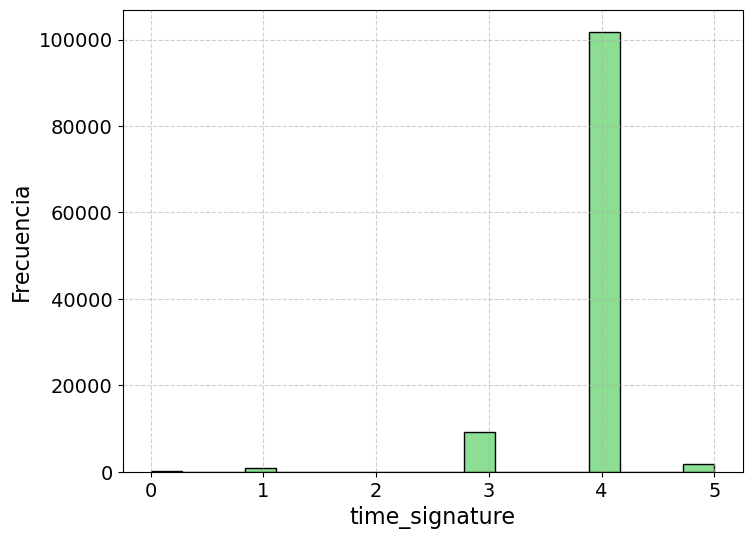

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cargar un dataset de ejemplo (puedes usar tu propio DataFrame)

# Configurar el tamaño del texto
font_size = 16

# Crear histogramas con Matplotlib
for column in numeric_features.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=False, color=(101/255,212/255,110/255))  # Histograma con densidad
    
    # Personalización de los ejes y título
    plt.xlabel(column, fontsize=font_size)
    plt.ylabel('Frecuencia', fontsize=font_size)
    plt.xticks(fontsize=font_size - 2)
    plt.yticks(fontsize=font_size - 2)
    
    # Agregar una cuadrícula para mejor visualización
    plt.grid(True, linestyle="--", alpha=0.6)

    # Guardar la figura como archivo de imagen
    file_name = f"histograma_{column}.png"
    plt.savefig(file_name, dpi=400, bbox_inches='tight')

    # Mostrar la figura
    plt.show()


Lo primero que nos llama la atención en este dataset, es que hay un identificador de canciones, llamado `track_id`, el cual está repetido en diversas ocasiones en el dataset.



In [27]:
# Para ello vamos a hacer un groupby con el track_id y analizar qué es lo que pasa

df.groupby('track_id').count().sort_values(by='track_name', ascending=False).head(5).to_excel('top_tracks.xlsx')

In [28]:
df.groupby('track_id').count().groupby('track_name').count()

,Unnamed: 0,artists,album_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
track_name,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099,73099
2,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712,11712
3,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984
4,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372
5,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431
6,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117
7,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
8,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Podemos observar, que hay una misma canción con distintos tipos de género, tenemos que ver como manejamos posteriormente esta transformación.

Agrupamos para cada `track_id` todos los géneros que aparecen para una misma canción en una lista.

In [29]:
# Quitar columnas innecesarias
df.drop(columns = ['Unnamed: 0'], inplace=True)
# Comprobar los valores de time_signature
df['time_signature'].value_counts()
# Quitar los valores que tienen 0 de time_signature
df = df[df['time_signature'] != 0]
# Quitar las canciones con duración 0
df = df[df['duration_ms'] > 0]
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
popularity,113836.0,33.233476,22.316549,0.00000,17.0000,34.000000,50.0000,100.000
duration_ms,113836.0,228109.608085,106308.371464,15800.00000,174198.0000,213000.000000,261587.0000,5237295.000
danceability,113836.0,0.567590,0.172379,0.05130,0.4560,0.580000,0.6950,0.985
energy,113836.0,0.642112,0.250786,0.00002,0.4730,0.685000,0.8540,1.000
key,113836.0,5.309199,3.559429,0.00000,2.0000,5.000000,8.0000,11.000
loudness,113836.0,-8.239513,4.992758,-46.59100,-10.0020,-6.998000,-5.0000,4.532
mode,113836.0,0.637496,0.480725,0.00000,0.0000,1.000000,1.0000,1.000
speechiness,113836.0,0.084770,0.105762,0.02210,0.0359,0.048900,0.0846,0.965
acousticness,113836.0,0.314642,0.332332,0.00000,0.0169,0.168000,0.5970,0.996
instrumentalness,113836.0,0.155362,0.308884,0.00000,0.0000,0.000041,0.0477,1.000


### Conversión de db a W

In [30]:
def convertir_a_decibelios(sonido):
    return 10**(-12) * 10**((sonido)/10)

df['loudness'] = df['loudness'].apply(convertir_a_decibelios)

## Relación entre danzabilidad y género

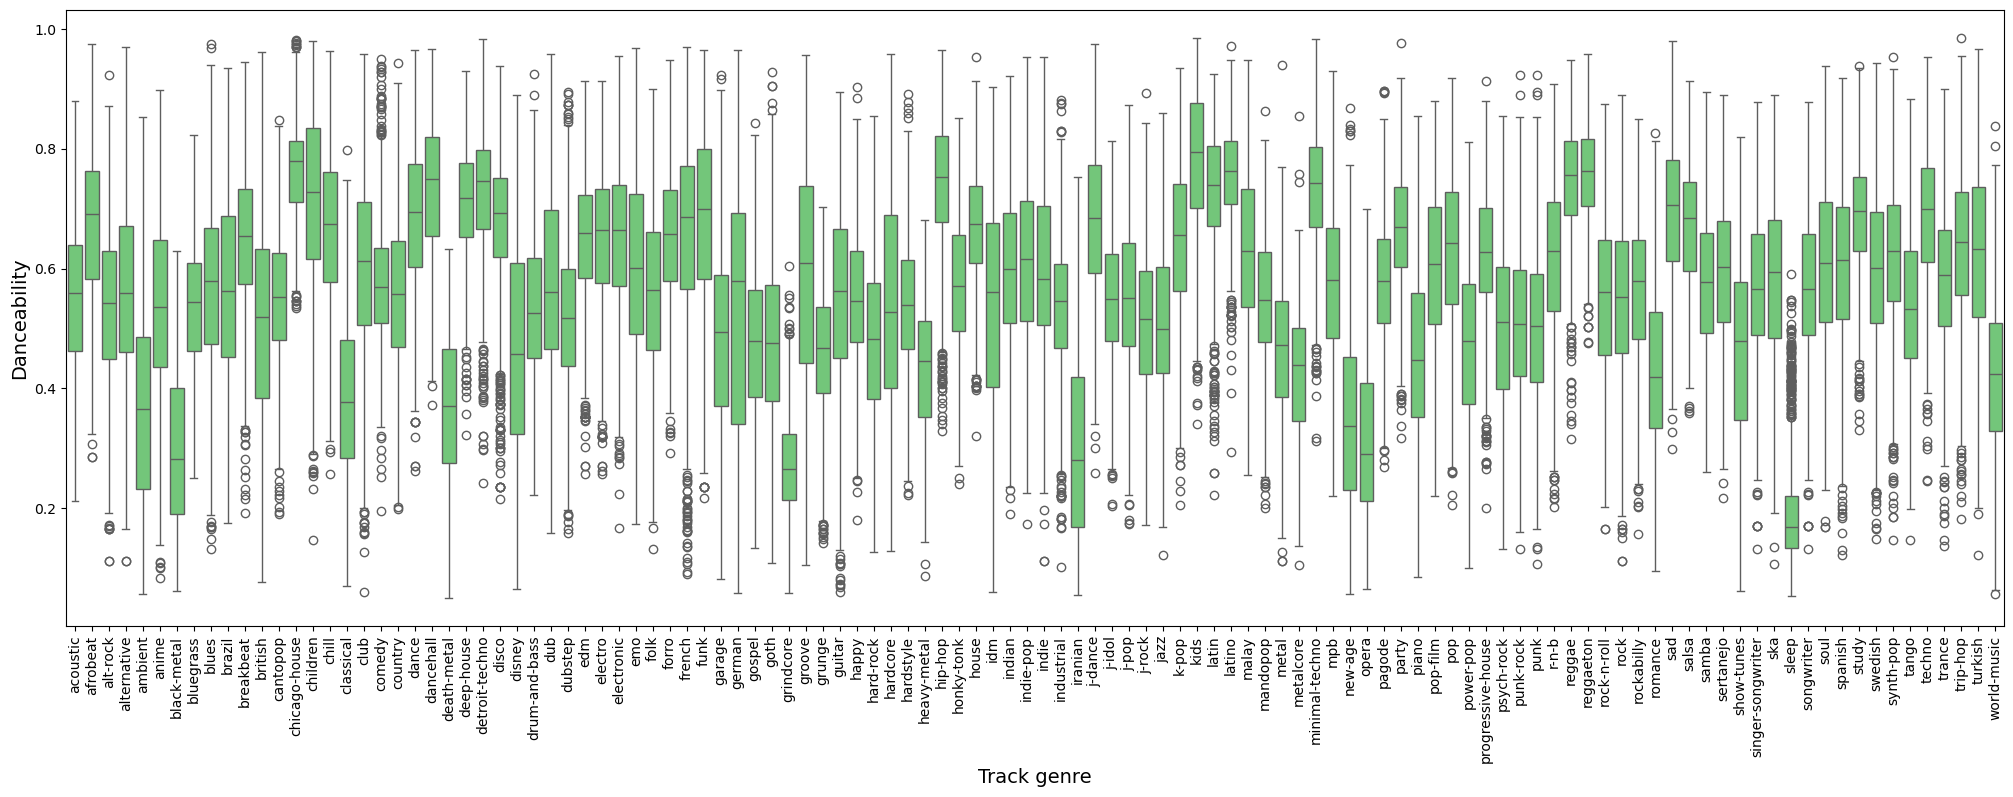

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 8))
sns.boxplot(x='track_genre', y='danceability', data=df, color=(101/255,212/255,110/255))
plt.xlabel('Track genre', fontsize = 14)
plt.ylabel('Danceability', fontsize = 14)
plt.xticks(rotation=90)
plt.savefig('danceability_genre.png', dpi = 500, bbox_inches = 'tight')
plt.show()


## Relación entre energía y loudness

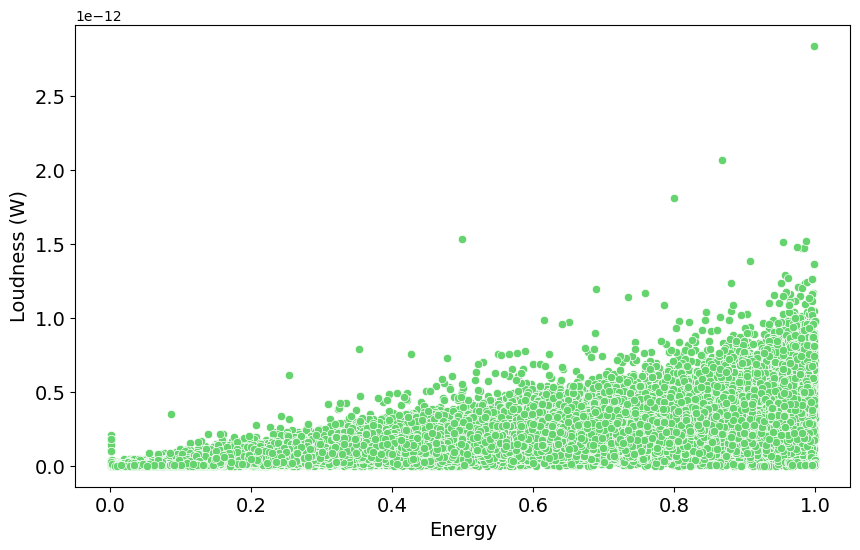

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='loudness', data=df, color=(101/255,212/255,110/255))
#plt.title('Energy vs Loudness')
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Loudness (W)', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('energy_vs_loudness_W.png', dpi=300, bbox_inches='tight')
plt.show()

## Matriz de correlaciones

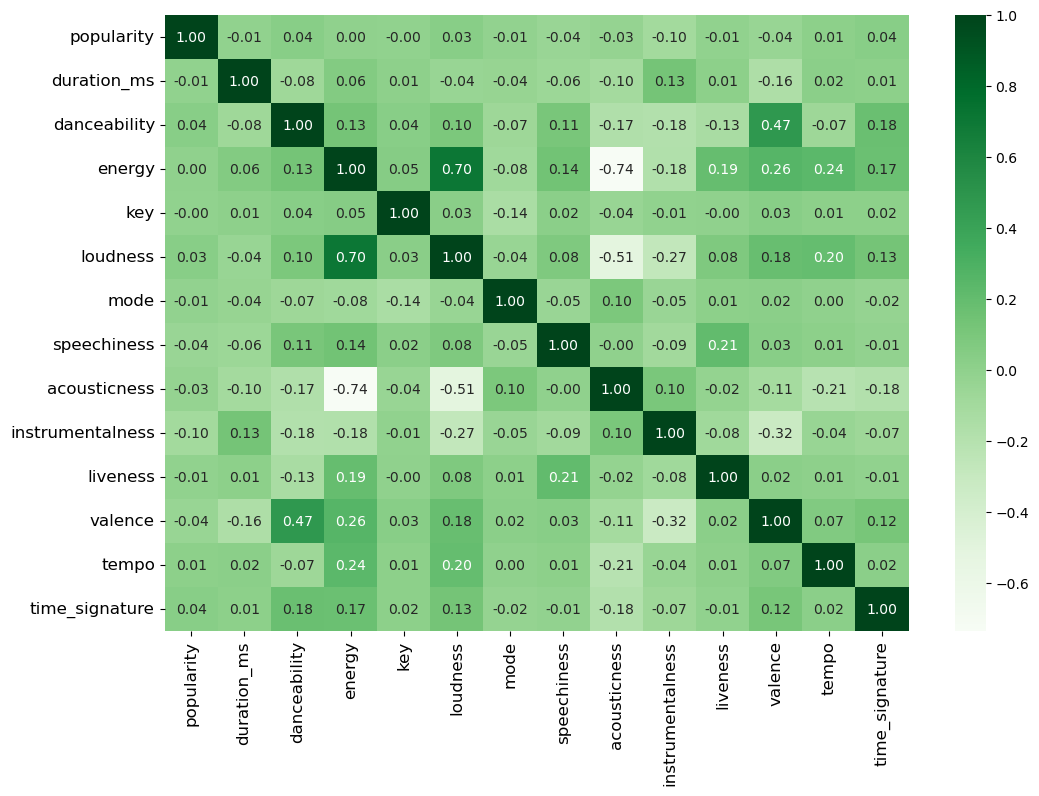

In [33]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features, annot=True, cmap='Greens', fmt='.2f')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Resolución problema multiclase

Empezamos reduciendo la dimensionalidad del problema reduciendo la muestra únicamente a aquellas canciones que están clasificadas únicamente en un género, para tener una idea de cómo abordar el problema más fácilmente 

In [34]:
# Diccionario de agrupación manual
genre_mapping = {
    # 🎸 Rock y derivados
    "hard-rock": "rock",
    "rock": "rock",
    "rock-n-roll": "rock",
    "alt-rock": "rock",
    "garage": "rock",
    "grunge": "rock",
    "psych-rock": "rock",
    "punk-rock": "rock",
    "punk": "rock",
    "hardcore": "rock",
    "indie-rock": "rock",
    
    # 🤘 Metal y variantes
    "heavy-metal": "metal",
    "black-metal": "metal",
    "death-metal": "metal",
    "metal": "metal",
    "metalcore": "metal",
    "grindcore": "metal",
    "groove": "metal",
    
    # 🎧 Electrónica y variantes
    "edm": "electronic",
    "electro": "electronic",
    "electronic": "electronic",
    "synth-pop": "electronic",
    "dubstep": "electronic",
    "techno": "electronic",
    "minimal-techno": "electronic",
    "detroit-techno": "electronic",
    "house": "electronic",
    "deep-house": "electronic",
    "progressive-house": "electronic",
    "trance": "electronic",
    "drum-and-bass": "electronic",
    "idm": "electronic",
    "breakbeat": "electronic",
    "club": "electronic",
    
    # 🎤 Hip-Hop / R&B
    "hip-hop": "hip-hop_rnb",
    "r-n-b": "hip-hop_rnb",
    
    # 🎼 Pop y variantes
    "pop": "pop",
    "indie-pop": "pop",
    "british": "pop",
    "power-pop": "pop",
    "mandopop": "pop",
    "cantopop": "pop",
    "j-pop": "pop",
    "k-pop": "pop",
    
    # 🌎 Música Latina y Tropical
    "latin": "latin",
    "latino": "latin",
    "brazil": "latin",
    "mpb": "latin",
    "pagode": "latin",
    "samba": "latin",
    "forro": "latin",
    "sertanejo": "latin",
    "tango": "latin",
    "salsa": "latin",
    "reggaeton": "latin",
    
    # 🎶 Música clásica y ambiental
    "classical": "classical",
    "piano": "classical",
    "opera": "classical",
    "ambient": "classical",
    
    # 🎷 Jazz, Soul, Blues
    "jazz": "jazz_soul",
    "soul": "jazz_soul",
    "blues": "jazz_soul",
    
    # 🎶 Folk y cantautores
    "folk": "folk_songwriter",
    "songwriter": "folk_songwriter",
    "singer-songwriter": "folk_songwriter",
    
    # 🎵 Música alternativa y experimental
    "alternative": "alternative",
    "indie": "alternative",
    "emo": "alternative",
    "goth": "alternative",
    
    # 🏠 Música de hogar y relajación
    "chill": "chill_sleep",
    "sleep": "chill_sleep",
    "study": "chill_sleep",
    
    # 🎭 Bandas sonoras y música de cine
    "disney": "soundtrack",
    "pop-film": "soundtrack",
    "show-tunes": "soundtrack",
    
    # 🕺 Funk, Disco y Groove
    "funk": "funk_disco",
    "disco": "funk_disco",
    "groove": "funk_disco",
    
    # 🎹 Música instrumental y guitarra
    "acoustic": "instrumental",
    "guitar": "instrumental",
    
    # 🌍 Música del mundo
    "world-music": "world",
    "turkish": "world",
    "iranian": "world",
    "afrobeat": "world",
    "indian": "world",
    "malay": "world",
    "gospel": "world",
    
    # 🎡 Música infantil
    "children": "children",
    "kids": "children",
    
    # 🎵 Otros géneros
    "comedy": "comedy",
    "party": "party",
    "happy": "party",
    "honky-tonk": "country",
    "country": "country",
    "industrial": "industrial",
    "new-age": "new-age",
    "dub": "dub",
    "dance": "dancehall",
    "dancehall": "dancehall",
    "ska": "ska",
    "trip-hop": "trip-hop",
    "romance": "romance",
    "sad": "romance",
    
    # Incluidos en version 2
    "anime": "soundtrack",  # Música relacionada con anime, similar a bandas sonoras
    "bluegrass": "folk_songwriter",  # Subgénero del folk con raíces en EE.UU.
    "chicago-house": "electronic",  # Subgénero del house, dentro de electrónica
    "french": "world",  # Música francesa, dentro de música del mundo
    "german": "world",  # Música alemana, dentro de música del mundo
    "hardstyle": "electronic",  # Subgénero de electrónica, similar a techno y trance
    "j-dance": "pop",  # Subgénero japonés relacionado con pop y dance
    "j-idol": "pop",  # Música idol japonesa, en pop
    "j-rock": "rock",  # Rock japonés, dentro de rock
    "reggae": "world",  # Reggae dentro de música del mundo
    "rockabilly": "rock",  # Subgénero de rock & roll
    "spanish": "world",  # Música en español dentro de música del mundo
    "swedish": "world",  # Música sueca dentro de música del mundo
    
}

df_single_genre = df.copy()
# Función para mapear cada género dentro de la lista
def map_genres(genre_list):
    if isinstance(genre_list, (list, tuple)):  # Si es una lista o tupla
        return [genre_mapping.get(genre, genre) for genre in genre_list]  # Mapea cada elemento
    return genre_mapping.get(genre_list, genre_list)  # Si es un string, mapear directamente

# Aplicar la función a la columna
df_single_genre["track_genre"] = df_single_genre["track_genre"].apply(map_genres)


In [35]:
df_single_genre = df_single_genre.groupby(['track_id', 'track_name'])['track_genre'].apply(lambda x: list(set(x))).reset_index().\
    merge(df, on='track_id', how='left').drop_duplicates(subset='track_id').\
    drop(columns=['track_genre_y', 'track_name_y']).rename(columns={'track_name_x': 'track_name', 'track_genre_x': 'track_genre'})

In [36]:
# Nos quedamos únicamente con aquellas canciones que tienen un solo género
df_single_genre = df_single_genre[df_single_genre['track_genre'].apply(lambda x: len(x) == 1)]

In [37]:
# 🔹 Convertir la columna a strings, eliminando caracteres innecesarios
df_single_genre['track_genre'] = df_single_genre.apply(lambda x: x['track_genre'][0], axis=1)
# 📌 Contar cuántas canciones hay en cada género
genre_counts = df_single_genre['track_genre'].value_counts()

# 📌 Filtrar solo los géneros que tienen al menos 900 canciones
filtered_genres = genre_counts[genre_counts >= 900]

# 📌 Obtener el mínimo número de canciones en estos géneros
n_min_genre = filtered_genres.min()

# 📌 Aplicar undersampling solo a los géneros que cumplen la condición
df_balanced = df_single_genre[df_single_genre['track_genre'].isin(filtered_genres.index)]\
    .groupby('track_genre', group_keys=False)\
    .apply(lambda x: x.sample(n=n_min_genre, random_state=42))\
    .reset_index(drop=True)

print("✅ Dataset balanceado correctamente con", df_balanced.shape[0], "filas")


✅ Dataset balanceado correctamente con 19888 filas


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3168279288.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_min_genre, random_state=42))\


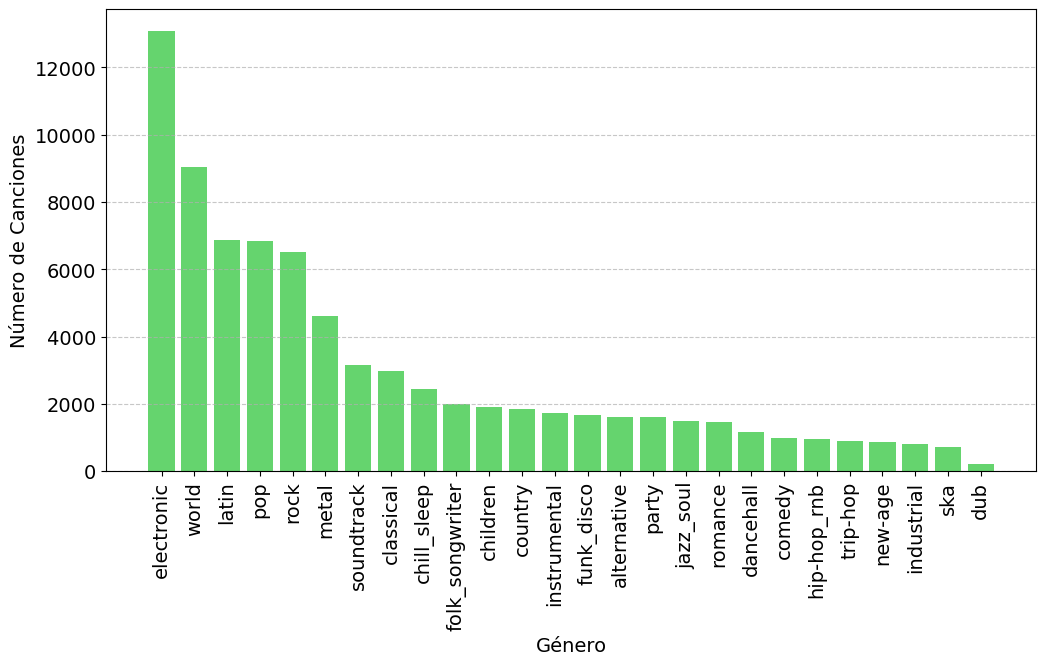

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que los géneros sean strings en lugar de tuplas
df_single_genre['track_genre'] = df_single_genre['track_genre'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

# Contar el número de canciones por género
genre_counts = df_single_genre['track_genre'].value_counts()

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color = (101/255,212/255,110/255))

# Personalizar el gráfico
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Género", fontsize = 14)
plt.ylabel("Número de Canciones", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('histograma_generos.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()

### Binarización de géneros 

In [39]:
from sklearn.preprocessing import OneHotEncoder

df_balanced['track_genre'] = df_balanced['track_genre'].astype(str).str.strip("(),'") # Convertir a string las tuplas de genero
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(df_balanced[['track_genre']])
print("Dimensiones de y:", y.shape)

Dimensiones de y: (19888, 22)


### Selección de variables predictoras

In [40]:
# One-hot encoding de la variable time_signature, solo nos vamos a quedar con 3 y 4 porque son los más significantes
df_balanced = pd.concat([df_balanced, pd.get_dummies(df_balanced['time_signature'])], axis=1) 
df_balanced.drop(columns=['time_signature', 1,5], inplace = True)
df_balanced.rename(columns={3: 'time_signature_3', 4: 'time_signature_4'}, inplace=True)

In [41]:
features = [
    'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'time_signature_3', 'time_signature_4', 'mode', 'duration_ms',
    'key', 'loudness', 'acousticness', 'popularity'
]

X = df_balanced[features].copy()

# Opcional: llenar posibles nulos
imputer = SimpleImputer(strategy='mean')  # o la estrategia que estimes
X = imputer.fit_transform(X)

# Escalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X = scaler.fit_transform(X)


### División train-test

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)


### Entrenamiento Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# 📌 Definir Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# Entrenamiento
rf_model.fit(X_train, y_train.argmax(axis=1))  # Usamos .argmax() porque es multiclase

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación
print("📊 Classification Report - Random Forest:")
print(classification_report(y_test.argmax(axis=1), y_pred_rf))

f1_micro_rf = f1_score(y_test.argmax(axis=1), y_pred_rf, average='micro')
f1_macro_rf = f1_score(y_test.argmax(axis=1), y_pred_rf, average='macro')

print("F1-micro (RF):", f1_micro_rf)
print("F1-macro (RF):", f1_macro_rf)


📊 Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.28      0.19      0.23       151
           1       0.63      0.72      0.67       173
           2       0.75      0.74      0.75       191
           3       0.61      0.63      0.62       189
           4       0.93      0.86      0.89       187
           5       0.66      0.72      0.69       175
           6       0.49      0.67      0.57       174
           7       0.49      0.39      0.43       179
           8       0.43      0.39      0.41       190
           9       0.49      0.40      0.44       198
          10       0.53      0.64      0.58       182
          11       0.35      0.49      0.41       168
          12       0.75      0.51      0.61       182
          13       0.55      0.67      0.60       193
          14       0.63      0.79      0.70       179
          15       0.60      0.77      0.68       173
          16       0.42      0.22      0

In [44]:
import pandas as pd
from sklearn.metrics import classification_report

# 📌 Obtener el reporte de clasificación como diccionario
report_dict = classification_report(y_test.argmax(axis=1), y_pred_rf, target_names=ohe.categories_[0], output_dict=True)

# 📌 Convertir el diccionario en DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# 📌 Guardar en un archivo Excel
df_report.to_excel('classification_report.xlsx')

print("✅ Reporte de clasificación guardado como 'classification_report.xlsx'")


✅ Reporte de clasificación guardado como 'classification_report.xlsx'


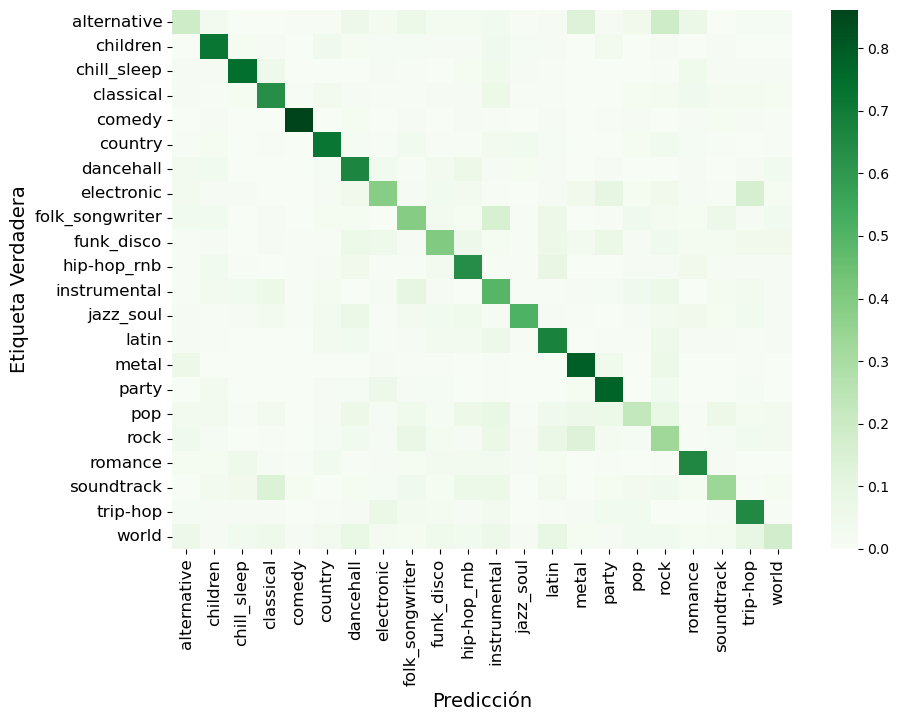

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 📌 Obtener la matriz de confusión
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_rf)  # Ajusta según el modelo que quieras visualizar

# 📌 Normalizar la matriz (opcional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 📌 Definir etiquetas
labels = ohe.categories_[0]  # Si usaste OneHotEncoder
# 📌 Plot de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=False, cmap="Greens", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Etiqueta Verdadera", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

## Red Neuronal

In [46]:
X = df_balanced[features].copy()

# Escalado para no saturar función de activación
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)


# ------------------------------------------------------------------
# 4. Definición de la red neuronal Keras
# ------------------------------------------------------------------
# Parámetros
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

# Definir la red neuronal
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation='relu'),  # Más neuronas para mayor capacidad
    layers.Dropout(0.4),  # Dropout para evitar sobreajuste
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_labels, activation='softmax')  # Softmax para clasificación multiclase
])

# Compilación del modelo
model.compile(
    loss='categorical_crossentropy',  # Pérdida para multiclase
    optimizer='adam',
    metrics=['accuracy']  # Accuracy es adecuada para multiclase
)

model.summary()

# ------------------------------------------------------------------
# 5. Entrenamiento
# ------------------------------------------------------------------
# Callbacks para un mejor manejo del entrenamiento

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Detener si no mejora
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)  # Reducir el learning rate dinámicamente
]

history = model.fit(
    X_train, 
    y_train, 
    epochs=60,         # Más épocas con EarlyStopping
    batch_size=16,     # Ajusta según tus datos
    validation_data=(X_test, y_test),
    callbacks=callbacks,  # Agregar callbacks para mejorar el entrenamiento
    verbose=1
)

# ------------------------------------------------------------------
# 6. Evaluación con métricas detalladas
# ------------------------------------------------------------------
# Generar predicciones
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)  # Obtener las clases predichas (índice de mayor probabilidad)
y_true = y_test.argmax(axis=1)  # Convertir one-hot encoding a clases originales

# Métricas detalladas
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=ohe.categories_[0]))

# Métricas globales
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

print("\n🔹 Métricas Globales:")
print(f"F1-micro: {f1_micro:.4f}")
print(f"F1-macro: {f1_macro:.4f}")
print(f"Precision-macro: {precision_macro:.4f}")
print(f"Recall-macro: {recall_macro:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,678 (182.34 KB)

 Trainable params: 46,678 (182.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.1625 - loss: 2.7602 - val_accuracy: 0.3338 - val_loss: 2.2136 - learning_rate: 0.0010
Epoch 2/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.2979 - loss: 2.3032 - val_accuracy: 0.3622 - val_loss: 2.0914 - learning_rate: 0.0010
Epoch 3/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.3266 - loss: 2.2073 - val_accuracy: 0.3786 - val_loss: 2.0286 - learning_rate: 0.0010
Epoch 4/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.3413 - loss: 2.1741 - val_accuracy: 0.3844 - val_loss: 1.9984 - learning_rate: 0.0010
Epoch 5/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.3581 - loss: 2.1285 - val_accuracy: 0.3947 - val_loss: 1.9695 - learning_rate: 0.0010
Epoch 6/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.3595 - loss: 2.1039 - val_accuracy: 0.3994 - val_loss: 1.9431 - learning_rate: 0.0010
Epoch 7/60
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.3687 - l

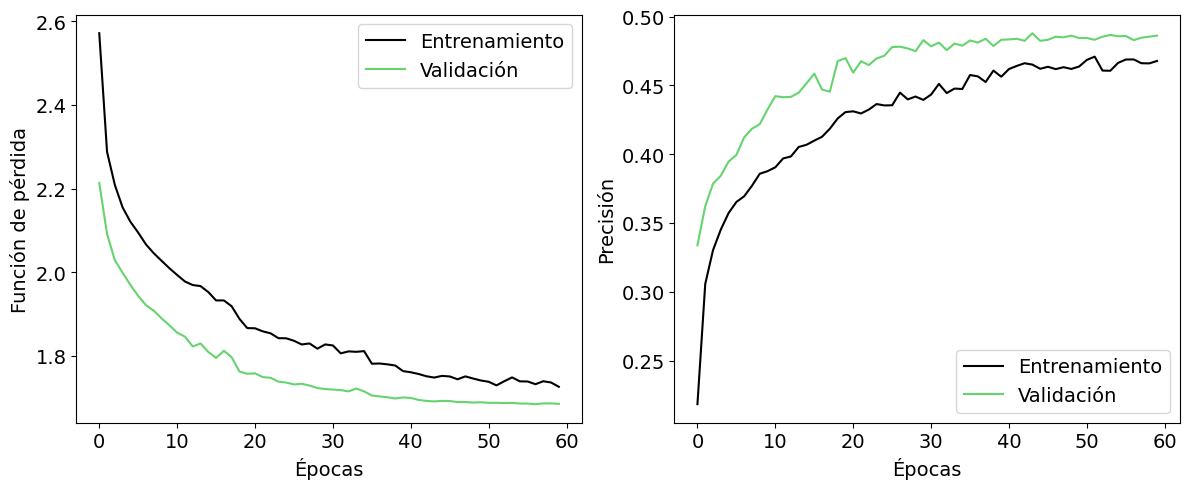

In [47]:
# Graficar pérdida y precisión
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento', color = 'black')
plt.plot(history.history['val_loss'], label='Validación', color = (101/255,212/255,110/255))
#plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas', fontsize = 14)
plt.ylabel('Función de pérdida', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento',  color = 'black')
plt.plot(history.history['val_accuracy'], label='Validación', color = (101/255,212/255,110/255))
#plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas', fontsize = 14)
plt.ylabel('Precisión', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)

plt.tight_layout()
plt.savefig('entrenamiento_validacion_red_neuronal.png', dpi=500, bbox_inches='tight')
plt.show()


In [48]:
import pandas as pd
from sklearn.metrics import classification_report

# 📌 Obtener el reporte de clasificación como diccionario
report_dict = classification_report(y_test.argmax(axis=1), y_pred, target_names=ohe.categories_[0], output_dict=True)

# 📌 Convertir el diccionario en DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# 📌 Guardar en un archivo Excel
df_report.to_excel('red_neuronal_mutliclase_classification_report.xlsx')

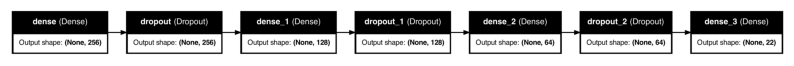

In [49]:
# Guardar el esquema de la red neuronal en un archivo
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, rankdir="LR")

# Mostrar la imagen generada
img = PIL.Image.open("model_architecture.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


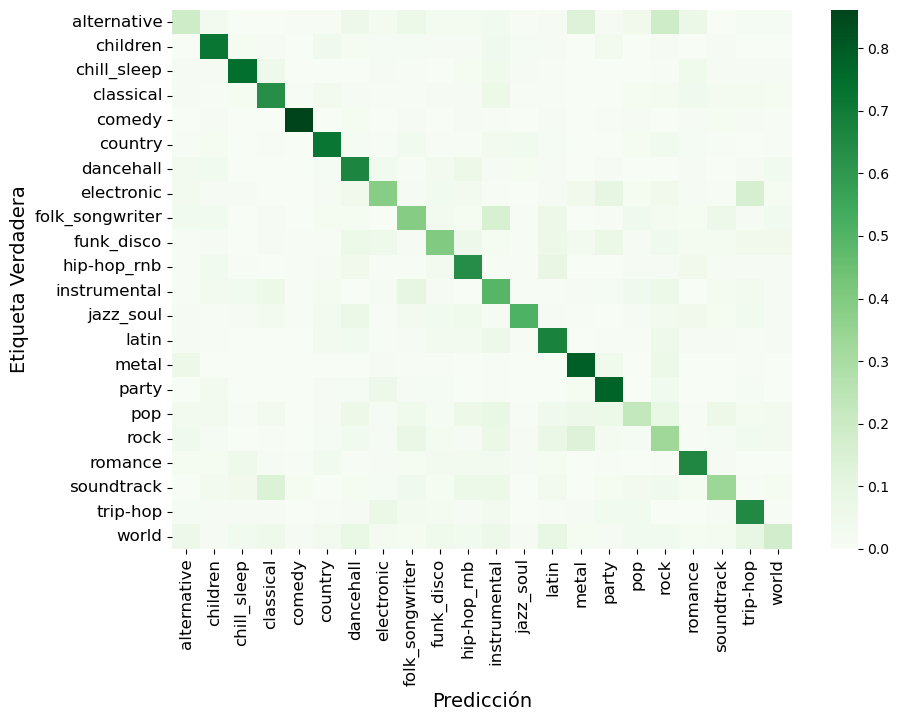

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 📌 Obtener la matriz de confusión
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_rf)  # Ajusta según el modelo que quieras visualizar

# 📌 Normalizar la matriz (opcional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 📌 Definir etiquetas
labels = ohe.categories_[0]  # Si usaste OneHotEncoder
# 📌 Plot de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=False, cmap="Greens", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Etiqueta Verdadera", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('matriz_confusion_red_neuronal_multiclase.png', dpi=300, bbox_inches='tight')
plt.show()

## PCA y Clúster

In [51]:
df_single_genre['track_genre'] = df_single_genre['track_genre'].astype(str).str.strip("(),'") # Convertir a string las tuplas de genero
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(df_single_genre[['track_genre']])
print("Dimensiones de y:", y.shape)

Dimensiones de y: (77500, 26)


In [52]:
features = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'mode', 'duration_ms', 'key', 'loudness', 'acousticness', 'popularity']
X = df_single_genre[features].copy()

# Escalado
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)


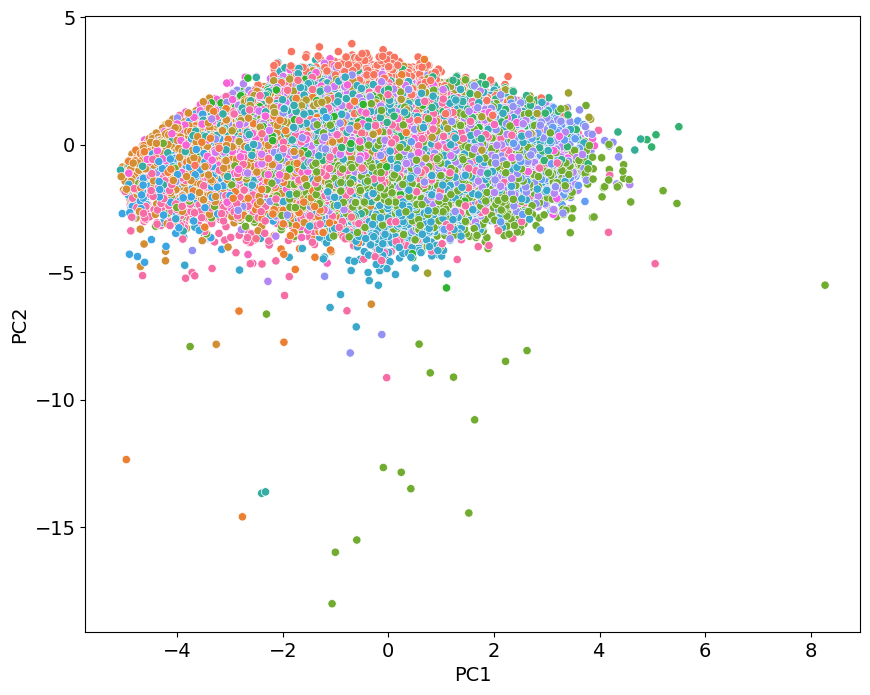

In [53]:
palette = sns.color_palette("husl", n_colors=26)  # 25 colores distintos
# 📌 Aplicamos PCA para reducir a 2 dimensiones (para visualización)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# 📌 Convertimos a un DataFrame para analizar
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["genre"] = y_train.argmax(axis=1)  # Asignamos los géneros originales

# 📌 Visualizamos los géneros en el espacio PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=pca_df["genre"], palette=palette, alpha=1, legend = False)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('pca_generos.png', dpi=300, bbox_inches='tight')
plt.show()


In [54]:
num_clusters = 20  # 📌 Define el número de categorías a reducir
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)
df_single_genre = df_single_genre.iloc[:X_pca.shape[0]].reset_index(drop=True)
# 📌 Asignamos los clusters como nuevas etiquetas de género
df_single_genre["cluster"] = clusters
df_single_genre["new_genre"] = df_single_genre["cluster"].astype(str)  # Convertimos el cluster en una nueva etiqueta de género

# 📌 Ver cuántos géneros hay en cada nuevo grupo
print(df_single_genre["new_genre"].value_counts())


new_genre
1     5595
6     4739
15    4663
16    4577
10    4076
3     3917
2     3791
14    3738
17    3412
7     3218
8     3171
0     3041
11    2571
12    2530
9     2236
13    2192
18    2084
5     1346
19    1079
4       24
Name: count, dtype: int64


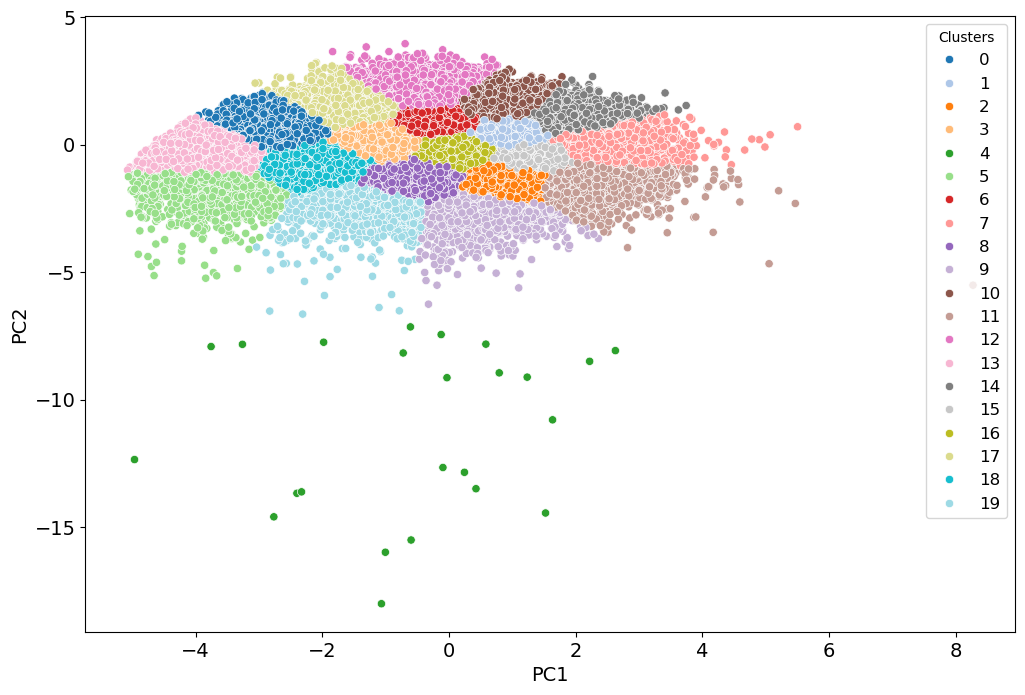

In [55]:
# 📌 Graficamos los clusters en el espacio PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1], hue=clusters, palette="tab20", alpha=1, legend = True)

# 📌 Agregamos etiquetas y título
plt.xlabel("PC1", fontsize = 14)
plt.ylabel("PC2", fontsize = 14)
plt.legend(title="Clusters", fontsize = 12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()


In [56]:
# 📌 Obtener los centroides de los clusters
centroids = kmeans.cluster_centers_

# 📌 Calcular la distancia de cada punto a su centroide correspondiente
distances = cdist(X_pca, centroids, metric="euclidean")

# 📌 Encontrar los 10 puntos más cercanos a cada centroide
closest_indices = np.argsort(distances, axis=0)[:10, :]  # Seleccionamos los 10 más cercanos

# 📌 Asociar cada índice con su género correspondiente
cluster_top_genres = {}

for cluster in range(kmeans.n_clusters):
    top_genres = df_single_genre.iloc[closest_indices[:, cluster]]["track_genre"].astype(str).tolist()
    cluster_top_genres[cluster] = top_genres  # Aseguramos que sean strings

# 📌 Mostrar los resultados
print("📊 Top 10 Géneros más cercanos a cada centroide:")
for cluster, genres in cluster_top_genres.items():
    print(f"Cluster {cluster}: {', '.join(genres)}")


📊 Top 10 Géneros más cercanos a cada centroide:
Cluster 0: ska, rock, rock, electronic, classical, rock, metal, electronic, chill_sleep, metal
Cluster 1: soundtrack, electronic, classical, soundtrack, electronic, romance, metal, classical, world, rock
Cluster 2: rock, folk_songwriter, electronic, rock, industrial, funk_disco, latin, world, latin, instrumental
Cluster 3: classical, metal, electronic, classical, rock, chill_sleep, pop, pop, latin, rock
Cluster 4: electronic, metal, electronic, alternative, electronic, world, rock, world, electronic, electronic
Cluster 5: classical, electronic, alternative, comedy, latin, soundtrack, metal, rock, children, electronic
Cluster 6: world, metal, dancehall, funk_disco, folk_songwriter, pop, dub, pop, latin, electronic
Cluster 7: world, latin, world, latin, latin, world, soundtrack, rock, electronic, industrial
Cluster 8: classical, latin, country, electronic, pop, electronic, latin, rock, dancehall, electronic
Cluster 9: electronic, world, fun

# Resolución del problema multietiqueta

In [57]:
df = pd.read_csv('./dataset.csv')

In [58]:
# Juntamos cada track_id con sus géneros
df_genre = df.groupby(['track_id', 'track_name'])['track_genre'].apply(lambda x: tuple(set(x))).reset_index().\
    merge(df, on='track_id', how='left').drop_duplicates(subset='track_id').\
    drop(columns=['track_genre_y', 'track_name_y']).rename(columns={'track_name_x': 'track_name', 'track_genre_x': 'track_genre'})

In [59]:
# Diccionario de agrupación manual
genre_mapping = {
    # 🎸 Rock y derivados
    "hard-rock": "rock",
    "rock": "rock",
    "rock-n-roll": "rock",
    "alt-rock": "rock",
    "garage": "rock",
    "grunge": "rock",
    "psych-rock": "rock",
    "punk-rock": "rock",
    "punk": "rock",
    "hardcore": "rock",
    "indie-rock": "rock",
    
    # 🤘 Metal y variantes
    "heavy-metal": "metal",
    "black-metal": "metal",
    "death-metal": "metal",
    "metal": "metal",
    "metalcore": "metal",
    "grindcore": "metal",
    "groove": "metal",
    
    # 🎧 Electrónica y variantes
    "edm": "electronic",
    "electro": "electronic",
    "electronic": "electronic",
    "synth-pop": "electronic",
    "dubstep": "electronic",
    "techno": "electronic",
    "minimal-techno": "electronic",
    "detroit-techno": "electronic",
    "house": "electronic",
    "deep-house": "electronic",
    "progressive-house": "electronic",
    "trance": "electronic",
    "drum-and-bass": "electronic",
    "idm": "electronic",
    "breakbeat": "electronic",
    "club": "electronic",
    
    # 🎤 Hip-Hop / R&B
    "hip-hop": "hip-hop_rnb",
    "r-n-b": "hip-hop_rnb",
    
    # 🎼 Pop y variantes
    "pop": "pop",
    "indie-pop": "pop",
    "british": "pop",
    "power-pop": "pop",
    "mandopop": "pop",
    "cantopop": "pop",
    "j-pop": "pop",
    "k-pop": "pop",
    
    # 🌎 Música Latina y Tropical
    "latin": "latin",
    "latino": "latin",
    "brazil": "latin",
    "mpb": "latin",
    "pagode": "latin",
    "samba": "latin",
    "forro": "latin",
    "sertanejo": "latin",
    "tango": "latin",
    "salsa": "latin",
    "reggaeton": "latin",
    
    # 🎶 Música clásica y ambiental
    "classical": "classical",
    "piano": "classical",
    "opera": "classical",
    "ambient": "classical",
    
    # 🎷 Jazz, Soul, Blues
    "jazz": "jazz_soul",
    "soul": "jazz_soul",
    "blues": "jazz_soul",
    
    # 🎶 Folk y cantautores
    "folk": "folk_songwriter",
    "songwriter": "folk_songwriter",
    "singer-songwriter": "folk_songwriter",
    
    # 🎵 Música alternativa y experimental
    "alternative": "alternative",
    "indie": "alternative",
    "emo": "alternative",
    "goth": "alternative",
    
    # 🏠 Música de hogar y relajación
    "chill": "chill_sleep",
    "sleep": "chill_sleep",
    "study": "chill_sleep",
    
    # 🎭 Bandas sonoras y música de cine
    "disney": "soundtrack",
    "pop-film": "soundtrack",
    "show-tunes": "soundtrack",
    
    # 🕺 Funk, Disco y Groove
    "funk": "funk_disco",
    "disco": "funk_disco",
    "groove": "funk_disco",
    
    # 🎹 Música instrumental y guitarra
    "acoustic": "instrumental",
    "guitar": "instrumental",
    
    # 🌍 Música del mundo
    "world-music": "world",
    "turkish": "world",
    "iranian": "world",
    "afrobeat": "world",
    "indian": "world",
    "malay": "world",
    "gospel": "world",
    
    # 🎡 Música infantil
    "children": "children",
    "kids": "children",
    
    # 🎵 Otros géneros
    "comedy": "comedy",
    "party": "party",
    "happy": "party",
    "honky-tonk": "country",
    "country": "country",
    "industrial": "industrial",
    "new-age": "new-age",
    "dub": "dub",
    "dance": "dancehall",
    "dancehall": "dancehall",
    "ska": "ska",
    "trip-hop": "trip-hop",
    "romance": "romance",
    "sad": "romance",
    
    # Incluidos en version 2
    "anime": "soundtrack",  # Música relacionada con anime, similar a bandas sonoras
    "bluegrass": "folk_songwriter",  # Subgénero del folk con raíces en EE.UU.
    "chicago-house": "electronic",  # Subgénero del house, dentro de electrónica
    "french": "world",  # Música francesa, dentro de música del mundo
    "german": "world",  # Música alemana, dentro de música del mundo
    "hardstyle": "electronic",  # Subgénero de electrónica, similar a techno y trance
    "j-dance": "pop",  # Subgénero japonés relacionado con pop y dance
    "j-idol": "pop",  # Música idol japonesa, en pop
    "j-rock": "rock",  # Rock japonés, dentro de rock
    "reggae": "world",  # Reggae dentro de música del mundo
    "rockabilly": "rock",  # Subgénero de rock & roll
    "spanish": "world",  # Música en español dentro de música del mundo
    "swedish": "world",  # Música sueca dentro de música del mundo
    
}

df_multigenre = df_genre.copy()
# Función para mapear cada género dentro de la lista
def map_genres(genre_list):
    if isinstance(genre_list, (list, tuple)):  # Si es una lista o tupla
        return [genre_mapping.get(genre, genre) for genre in genre_list]  # Mapea cada elemento
    return genre_mapping.get(genre_list, genre_list)  # Si es un string, mapear directamente

# Aplicar la función a la columna
df_multigenre["track_genre"] = df_multigenre["track_genre"].apply(map_genres)


In [60]:
# De todas las listas que tenemos del género de las canciones vamos a ver cuántas listas iguales hay en todo el DataFrame.
# Para ello vamos a convertir todas las listas en tuplas, ya que estos sí son elementos hashables 
# y las vamos a ordenar para que se detecten como iguales las tuplas (a,b) y (b,a)
df_multigenre['track_genre_tuple'] = df_multigenre['track_genre'].apply(lambda x: tuple(sorted(x)))
tuplas_generos = df_multigenre.groupby('track_genre_tuple').count()
# Ahora vamos a aplicar un umbral de apariciones mínimo para que no se tengan en cuenta las tuplas que aparezcan menos de n_min_tuple veces
n_min_tuple = 5
tuplas_generos = tuplas_generos[tuplas_generos['track_id'] < n_min_tuple].index.to_list()

df_reduced = df_multigenre[~df_multigenre['track_genre_tuple'].isin(tuplas_generos)] # Eliminamos las tuplas con menos de n_min_tuple apariciones

In [61]:
# Vamos a eliminar ahora todas las listas de géneros que tengan más de n_max_genre elementos para simplificar el problema
n_max_genre = 3
df_reduced = df_reduced[df_reduced['track_genre'].apply(lambda x: len(x) <= n_max_genre)].reset_index(drop=True)

In [62]:
df_series =df_reduced.track_genre.value_counts()
df_series

track_genre
[electronic]                  11934
[world]                        9036
[pop]                          6677
[latin]                        6150
[rock]                         5627
                              ...  
[latin, rock, alternative]        1
[alternative, metal]              1
[pop, latin]                      1
[pop, world, electronic]          1
[alternative, pop]                1
Name: count, Length: 323, dtype: int64

In [63]:
# Balanceamos las clases para que haya un máximo de 50 canciones por cada combinación de géneros
df_reduced = df_reduced.groupby('track_genre_tuple', group_keys=False).apply(lambda x: x.sample(min(len(x), n_min_tuple)))

/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3943647684.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df_reduced.groupby('track_genre_tuple', group_keys=False).apply(lambda x: x.sample(min(len(x), n_min_tuple)))


In [64]:
# Una vez reducido el DataFrame vamos a contar las apariciones de cada género
pd.Series(list((genre for sublist in df_reduced['track_genre'] for genre in sublist))).value_counts() 

rock               345
pop                205
electronic         200
alternative        190
latin              185
world              185
jazz_soul          165
folk_songwriter    165
funk_disco         145
metal              140
classical          115
hip-hop_rnb        110
dancehall           70
soundtrack          60
instrumental        55
chill_sleep         50
party               45
ska                 40
dub                 35
industrial          35
country             30
romance             25
children            25
trip-hop            20
new-age             15
comedy               5
Name: count, dtype: int64

## Transformación a formato multi-label

Para poder entrenar un modelo supervisado, debemos convertir la lista de géneros de cada canción en vectores binarios (0/1) que indiquen la presencia o ausencia de cada género.

In [65]:
mlb = MultiLabelBinarizer()
# y será un array de forma (n_muestras, n_generos)
y = mlb.fit_transform(df_reduced['track_genre'])
print("Dimensiones de y:", y.shape)


Dimensiones de y: (1155, 26)


## Selección de variables predictoras

In [66]:
# One-hot encoding de la variable time_signature, solo nos vamos a quedar con 3 y 4 porque son los más significantes
df_reduced = pd.concat([df_reduced, pd.get_dummies(df_reduced['time_signature'])], axis=1) 

In [67]:
df_reduced.rename(columns={3: 'time_signature_3', 4: 'time_signature_4'}, inplace=True)

In [68]:
features = [
    'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'time_signature_3', 'time_signature_4', 'mode'
]

X = df_reduced[features].copy()

# Opcional: llenar posibles nulos
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # o la estrategia que estimes
X = imputer.fit_transform(X)

# Escalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


## División train-test

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)


## Red Neuronal

In [ ]:
# ------------------------------------------------------------------
# 1. Definición de la red neuronal Keras
# ------------------------------------------------------------------
# - Capa de salida con dimensión igual al número de géneros
# - Activación 'sigmoid' en la salida
# - Pérdida: 'binary_crossentropy'

n_features = X_train.shape[1]
n_labels = y_train.shape[1]

model = models.Sequential()
model.add(layers.Input(shape=(n_features,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# Capa de salida con neuronas = número de etiquetas y activación sigmoide
model.add(layers.Dense(n_labels, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']  # En multi-label, la 'accuracy' puede no ser tan representativa
)

model.summary()

# ------------------------------------------------------------------
# 2. Entrenamiento
# ------------------------------------------------------------------
history = model.fit(
    X_train, 
    y_train, 
    epochs=20,         # Ajusta según tu criterio, por ejemplo 20 o 50
    batch_size=32,     # Ajusta si deseas
    validation_data=(X_test, y_test),
    verbose=1
)

# ------------------------------------------------------------------
# 3. Evaluación con métricas clásicas (f1, precision, recall)
# ------------------------------------------------------------------
# La métrica de 'accuracy' en el entrenamiento es un promedio
# de aciertos a nivel individual (dependiendo la versión de TF).
# Para un análisis más detallado, calculamos F1, precision, recall
# en scikit-learn, generando predicciones con un umbral 0.5.

y_pred_proba = model.predict(X_test)
# Binarizamos con umbral 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Classification report (por etiqueta):")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Si prefieres f1 'micro' o 'macro':
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print("F1-micro:", f1_micro)
print("F1-macro:", f1_macro)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,642 (14.23 KB)

 Trainable params: 3,642 (14.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0430 - loss: 0.7038 - val_accuracy: 0.0216 - val_loss: 0.5914
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0343 - loss: 0.5459 - val_accuracy: 0.0260 - val_loss: 0.3926
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0375 - loss: 0.3489 - val_accuracy: 0.0563 - val_loss: 0.2821
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0469 - loss: 0.2706 - val_accuracy: 0.0346 - val_loss: 0.2608
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0494 - loss: 0.2510 - val_accuracy: 0.0779 - val_loss: 0.2537
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0850 - loss: 0.2449 - val_accuracy: 0.0996 - val_loss: 0.2500
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1224 - loss: 0.2409 - val_accuracy: 0.1255 - val_loss: 0.2473
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1372 - loss: 0.2368 - val_accuracy: 0.1212 - val_loss:

/Users/octa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/octa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/octa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/octa/anaco

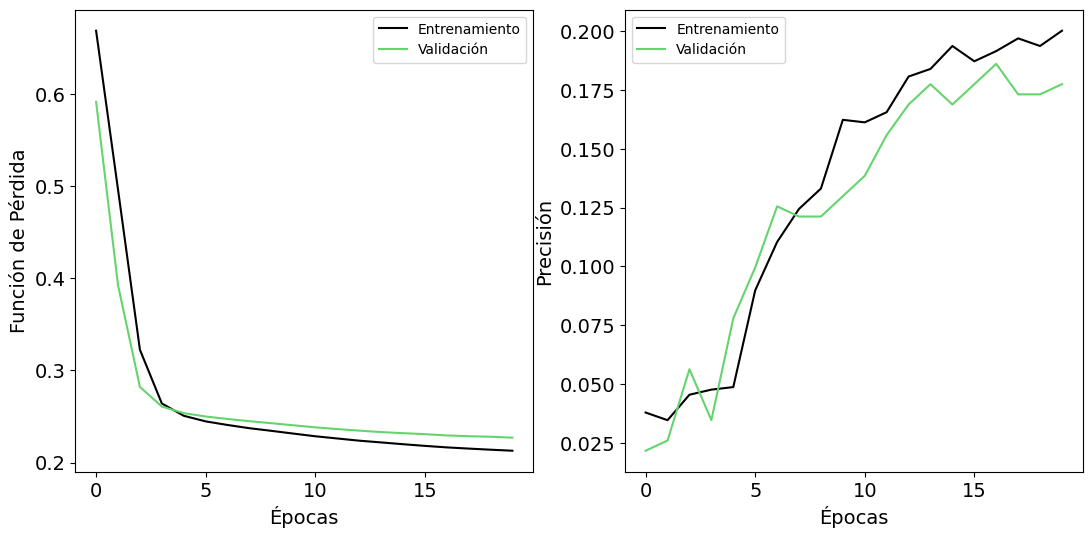

In [75]:
# Crear una figura con dos subgráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
# Gráfico de la función de pérdida
axes[0].plot(history.history['loss'], label='Entrenamiento', color='black')
axes[0].plot(history.history['val_loss'], label='Validación', color=(101/255, 212/255, 110/255))
axes[0].set_xlabel('Épocas', fontsize=14)
axes[0].set_ylabel('Función de Pérdida', fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].legend()

# Gráfico de la precisión
axes[1].plot(history.history['accuracy'], label='Entrenamiento', color='black')
axes[1].plot(history.history['val_accuracy'], label='Validación', color=(101/255, 212/255, 110/255))
axes[1].set_xlabel('Épocas', fontsize=14)
axes[1].set_ylabel('Precisión', fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].legend()

# Guardar las imágenes
plt.savefig('training_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


In [76]:
# 📌 Obtener el reporte de clasificación como diccionario en formato multietiqueta
report_dict = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)

# 📌 Convertir el diccionario en DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# 📌 Guardar en un archivo Excel
df_report.to_excel('classification_report_multietiqueta.xlsx')

print("✅ Reporte de clasificación guardado como 'classification_report_multietiqueta.xlsx'")


✅ Reporte de clasificación guardado como 'classification_report_multietiqueta.xlsx'


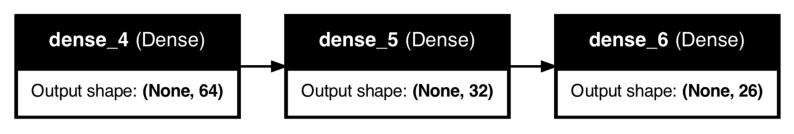

In [77]:
# Guardar el esquema de la red neuronal en un archivo
plot_model(model, to_file="model_architecture_multietiqueta.png", show_shapes=True, show_layer_names=True, rankdir="LR")

# Mostrar la imagen generada
img = PIL.Image.open("model_architecture_multietiqueta.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


## Resolución del problema One vs the Rest

In [78]:
df = pd.read_csv('./dataset.csv')

# Quitar columnas innecesarias
df.drop(columns = ['Unnamed: 0'], inplace=True)
# Comprobar los valores de time_signature
df['time_signature'].value_counts()
# Quitar los valores que tienen 0 de time_signature
df = df[df['time_signature'] != 0]
# Quitar las canciones con duración 0
df = df[df['duration_ms'] > 0]
df.describe().transpose()

def convertir_a_decibelios(sonido):
    return 10**(-12) * 10**((sonido)/10)

df['loudness'] = df['loudness'].apply(convertir_a_decibelios)

# Vamos a cambiar todos los géneros por los de genre_mapping, y tener repetidos los track_id
df["track_genre"] = df["track_genre"].map(genre_mapping)
df.track_genre.dropna(inplace=True)
df.track_genre.unique()

array(['instrumental', 'world', 'rock', 'alternative', 'classical',
       'soundtrack', 'metal', 'folk_songwriter', 'jazz_soul', 'latin',
       'electronic', 'pop', 'children', 'chill_sleep', 'comedy',
       'country', 'dancehall', 'funk_disco', 'dub', 'party',
       'hip-hop_rnb', 'industrial', 'new-age', 'romance', 'ska',
       'trip-hop'], dtype=object)

<Axes: xlabel='track_genre'>

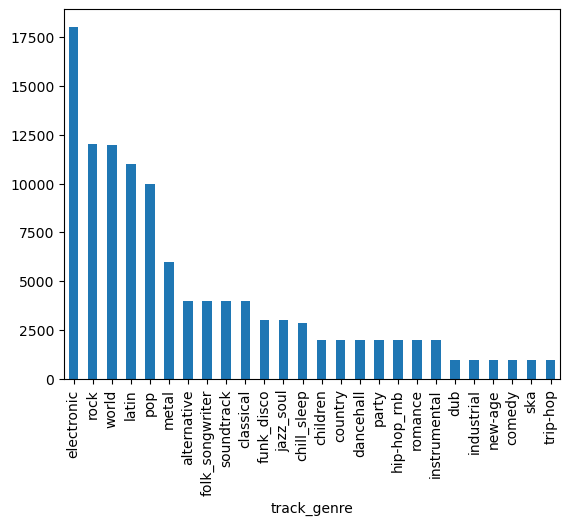

In [79]:
df.track_genre.value_counts().plot(kind = 'bar')

In [85]:
# Encontrar el número mínimo de muestras disponibles en cualquier género
min_value = df['track_genre'].value_counts().min()
print(min_value)

# Crear un DataFrame balanceado con la misma cantidad de ejemplos por clase
df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)

# Obtener los géneros únicos
unique_genres = df_balanced['track_genre'].unique()

# Diccionario para guardar modelos
models = {}

# Filtrar solo las columnas numéricas
features = [
'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 
'valence', 'tempo', 'popularity', 'mode'
]

for genre in unique_genres:
    print(f"\nEntrenando clasificador para: {genre}")
    
    df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)

    # Crear etiqueta binaria: 0 si es el género, 1 si no lo es
    df_balanced[f'label_{genre}'] = (df_balanced['track_genre'] != genre).astype(int)
    print(df_balanced[f'label_{genre}'].value_counts())

    # Si una canción es multigénero, para entrenar la eliminamos de los géneros que no estamos prediciendo
    df_balanced = df_balanced.sort_values(by=f'label_{genre}', ascending=True)  # Ordenamos para que genre (0) quede primero
    df_balanced = df_balanced.drop_duplicates(subset=['track_id'], keep='first')  # Mantiene solo la primera (genre)

    # Ahora vamos a balancear las clases 0 y 1 para entrenar los modelos
    # Separar en dos grupos
    df_majority = df_balanced[df_balanced[f'label_{genre}'] == 1]  # No genre
    df_minority = df_balanced[df_balanced[f'label_{genre}'] == 0]  # Genre

    # Reducir el grupo mayoritario al tamaño del minoritario
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,  # No reemplazo
                                    n_samples=len(df_minority),  # Igualar al minoritario
                                    random_state=42)  # Reproducibilidad

    # Unir los dos grupos
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Verificar el balance
    print('\n')
    print(df_balanced[f'label_{genre}'].value_counts())


    X = df_balanced[features].copy()
    y = df_balanced[f'label_{genre}']

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Entrenar modelo
    model = RandomForestClassifier(random_state=42, class_weight="balanced")
    model.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Accuracy for {genre}: {acc:.4f}")
    print(f"Precision for {genre}: {precision:.4f}")
    print(f"Recall for {genre}: {recall:.4f}")

    matriz_confusion = confusion_matrix(y_test, y_pred)
    print(f"\n Matriz de confusión para {genre}:")
    print(matriz_confusion)

    # Guardar modelo
    models[genre] = model


1000

Entrenando clasificador para: alternative
label_alternative
1    25000
0     1000
Name: count, dtype: int64


label_alternative
1    998
0    998
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)
/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genr

Accuracy for alternative: 0.6925
Precision for alternative: 0.6882
Recall for alternative: 0.6632

 Matriz de confusión para alternative:
[[149  58]
 [ 65 128]]

Entrenando clasificador para: children
label_children
1    25000
0     1000
Name: count, dtype: int64


label_children
1    996
0    996
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for children: 0.8195
Precision for children: 0.7905
Recall for children: 0.8557

 Matriz de confusión para children:
[[161  44]
 [ 28 166]]

Entrenando clasificador para: chill_sleep
label_chill_sleep
1    25000
0     1000
Name: count, dtype: int64


label_chill_sleep
1    1000
0    1000
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for chill_sleep: 0.8275
Precision for chill_sleep: 0.8218
Recall for chill_sleep: 0.8342

 Matriz de confusión para chill_sleep:
[[165  36]
 [ 33 166]]

Entrenando clasificador para: classical
label_classical
1    25000
0     1000
Name: count, dtype: int64


label_classical
1    987
0    987
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for classical: 0.8203
Precision for classical: 0.8098
Recall for classical: 0.8384

 Matriz de confusión para classical:
[[158  39]
 [ 32 166]]

Entrenando clasificador para: comedy
label_comedy
1    25000
0     1000
Name: count, dtype: int64


label_comedy
1    996
0    996
Name: count, dtype: int64
Accuracy for comedy: 0.9148
Precision for comedy: 0.8922
Recall for comedy: 0.9381

 Matriz de confusión para comedy:
[[183  22]
 [ 12 182]]

Entrenando clasificador para: country


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)
/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_gen

label_country
1    25000
0     1000
Name: count, dtype: int64


label_country
1    997
0    997
Name: count, dtype: int64
Accuracy for country: 0.8571
Precision for country: 0.8366
Recall for country: 0.8756

 Matriz de confusión para country:
[[173  33]
 [ 24 169]]

Entrenando clasificador para: dancehall
label_dancehall
1    25000
0     1000
Name: count, dtype: int64


label_dancehall
1    972
0    972
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for dancehall: 0.8329
Precision for dancehall: 0.8706
Recall for dancehall: 0.7749

 Matriz de confusión para dancehall:
[[176  22]
 [ 43 148]]

Entrenando clasificador para: dub
label_dub
1    25000
0     1000
Name: count, dtype: int64


label_dub
1    999
0    999
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for dub: 0.8375
Precision for dub: 0.8413
Recall for dub: 0.8454

 Matriz de confusión para dub:
[[160  33]
 [ 32 175]]

Entrenando clasificador para: electronic
label_electronic
1    25000
0     1000
Name: count, dtype: int64


label_electronic
1    994
0    994
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for electronic: 0.7588
Precision for electronic: 0.7402
Recall for electronic: 0.7784

 Matriz de confusión para electronic:
[[151  53]
 [ 43 151]]

Entrenando clasificador para: folk_songwriter
label_folk_songwriter
1    25000
0     1000
Name: count, dtype: int64


label_folk_songwriter
1    920
0    920
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for folk_songwriter: 0.8016
Precision for folk_songwriter: 0.8065
Recall for folk_songwriter: 0.8021

 Matriz de confusión para folk_songwriter:
[[145  36]
 [ 37 150]]

Entrenando clasificador para: funk_disco
label_funk_disco
1    25000
0     1000
Name: count, dtype: int64


label_funk_disco
1    994
0    994
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for funk_disco: 0.7387
Precision for funk_disco: 0.7320
Recall for funk_disco: 0.7320

 Matriz de confusión para funk_disco:
[[152  52]
 [ 52 142]]

Entrenando clasificador para: hip-hop_rnb
label_hip-hop_rnb
1    25000
0     1000
Name: count, dtype: int64


label_hip-hop_rnb
1    997
0    997
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for hip-hop_rnb: 0.8471
Precision for hip-hop_rnb: 0.8626
Recall for hip-hop_rnb: 0.8135

 Matriz de confusión para hip-hop_rnb:
[[181  25]
 [ 36 157]]

Entrenando clasificador para: industrial
label_industrial
1    25000
0     1000
Name: count, dtype: int64


label_industrial
1    1000
0    1000
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for industrial: 0.8475
Precision for industrial: 0.8416
Recall for industrial: 0.8543

 Matriz de confusión para industrial:
[[169  32]
 [ 29 170]]

Entrenando clasificador para: instrumental
label_instrumental
1    25000
0     1000
Name: count, dtype: int64


label_instrumental
1    993
0    993
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for instrumental: 0.7789
Precision for instrumental: 0.7593
Recall for instrumental: 0.8200

 Matriz de confusión para instrumental:
[[146  52]
 [ 36 164]]

Entrenando clasificador para: jazz_soul
label_jazz_soul
1    25000
0     1000
Name: count, dtype: int64


label_jazz_soul
1    974
0    974
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for jazz_soul: 0.7641
Precision for jazz_soul: 0.7429
Recall for jazz_soul: 0.8041

 Matriz de confusión para jazz_soul:
[[142  54]
 [ 38 156]]

Entrenando clasificador para: latin
label_latin
1    25000
0     1000
Name: count, dtype: int64


label_latin
1    974
0    974
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for latin: 0.7897
Precision for latin: 0.7692
Recall for latin: 0.8247

 Matriz de confusión para latin:
[[148  48]
 [ 34 160]]

Entrenando clasificador para: metal
label_metal
1    25000
0     1000
Name: count, dtype: int64


label_metal
1    989
0    989
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for metal: 0.9040
Precision for metal: 0.8916
Recall for metal: 0.9188

 Matriz de confusión para metal:
[[177  22]
 [ 16 181]]

Entrenando clasificador para: new-age
label_new-age
1    25000
0     1000
Name: count, dtype: int64


label_new-age
1    994
0    994
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for new-age: 0.9196
Precision for new-age: 0.9309
Recall for new-age: 0.9021

 Matriz de confusión para new-age:
[[191  13]
 [ 19 175]]

Entrenando clasificador para: party
label_party
1    25000
0     1000
Name: count, dtype: int64


label_party
1    1000
0    1000
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for party: 0.8675
Precision for party: 0.8614
Recall for party: 0.8744

 Matriz de confusión para party:
[[173  28]
 [ 25 174]]

Entrenando clasificador para: pop
label_pop
1    25000
0     1000
Name: count, dtype: int64


label_pop
1    1000
0    1000
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for pop: 0.6550
Precision for pop: 0.6432
Recall for pop: 0.6884

 Matriz de confusión para pop:
[[125  76]
 [ 62 137]]

Entrenando clasificador para: rock
label_rock
1    25000
0     1000
Name: count, dtype: int64


label_rock
1    983
0    983
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for rock: 0.6853
Precision for rock: 0.6786
Recall for rock: 0.6856

 Matriz de confusión para rock:
[[137  63]
 [ 61 133]]

Entrenando clasificador para: romance
label_romance
1    25000
0     1000
Name: count, dtype: int64


label_romance
1    966
0    966
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for romance: 0.8656
Precision for romance: 0.8488
Recall for romance: 0.8923

 Matriz de confusión para romance:
[[161  31]
 [ 21 174]]

Entrenando clasificador para: ska
label_ska
1    25000
0     1000
Name: count, dtype: int64


label_ska
1    1000
0    1000
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for ska: 0.9100
Precision for ska: 0.9055
Recall for ska: 0.9146

 Matriz de confusión para ska:
[[182  19]
 [ 17 182]]

Entrenando clasificador para: soundtrack
label_soundtrack
1    25000
0     1000
Name: count, dtype: int64


label_soundtrack
1    997
0    997
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for soundtrack: 0.7644
Precision for soundtrack: 0.7929
Recall for soundtrack: 0.6943

 Matriz de confusión para soundtrack:
[[171  35]
 [ 59 134]]

Entrenando clasificador para: trip-hop
label_trip-hop
1    25000
0     1000
Name: count, dtype: int64


label_trip-hop
1    997
0    997
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for trip-hop: 0.8471
Precision for trip-hop: 0.8367
Recall for trip-hop: 0.8497

 Matriz de confusión para trip-hop:
[[174  32]
 [ 29 164]]

Entrenando clasificador para: world
label_world
1    25000
0     1000
Name: count, dtype: int64


label_world
1    997
0    997
Name: count, dtype: int64


/var/folders/wy/t0vzzgmd2b94w25qyllnrx0m0000gn/T/ipykernel_33525/3858934541.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('track_genre').apply(lambda x: x.sample(min_value, random_state=42)).reset_index(drop=True)


Accuracy for world: 0.6642
Precision for world: 0.6595
Recall for world: 0.6321

 Matriz de confusión para world:
[[143  63]
 [ 71 122]]


In [86]:
models.items()

dict_items([('alternative', RandomForestClassifier(class_weight='balanced', random_state=42)), ('children', RandomForestClassifier(class_weight='balanced', random_state=42)), ('chill_sleep', RandomForestClassifier(class_weight='balanced', random_state=42)), ('classical', RandomForestClassifier(class_weight='balanced', random_state=42)), ('comedy', RandomForestClassifier(class_weight='balanced', random_state=42)), ('country', RandomForestClassifier(class_weight='balanced', random_state=42)), ('dancehall', RandomForestClassifier(class_weight='balanced', random_state=42)), ('dub', RandomForestClassifier(class_weight='balanced', random_state=42)), ('electronic', RandomForestClassifier(class_weight='balanced', random_state=42)), ('folk_songwriter', RandomForestClassifier(class_weight='balanced', random_state=42)), ('funk_disco', RandomForestClassifier(class_weight='balanced', random_state=42)), ('hip-hop_rnb', RandomForestClassifier(class_weight='balanced', random_state=42)), ('industrial',

In [87]:
# Iterar sobre cada modelo entrenado
prob_df = pd.DataFrame()
X = df[features].copy()
for genre, model in models.items():
    prob_df[genre] = model.predict_proba(X)[:, 1]  # Probabilidad de ser del género

In [88]:
# Vamos a hacer un join con el DataFrame original
df_join = df.join(prob_df)
df_join

# Vamos a exportar los resultados a un excel
df_join.to_excel('predicciones_generos.xlsx', index=False)

In [89]:
X = df[features].copy()
prob_df = pd.DataFrame()
for genre, model in models.items():
    prob_df[genre] = model.predict_proba(X)[:, 1]  # Probabilidad de ser del género
    

In [90]:
df_multigenre

,track_id,track_name,track_genre,Unnamed: 0,artists,album_name,popularity,duration_ms,explicit,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre_tuple
0,0000vdREvCVMxbQTkS888c,Lolly,[world],39463,Rill,Lolly,44,160725,True,0.910,...,-9.844,0,0.1990,0.075700,0.00301,0.1540,0.432,104.042,4,"(world,)"
1,000CC8EParg64OmTxVnZ0p,It's All Coming Back To Me Now (Glee Cast Vers...,[electronic],17586,Glee Cast,Glee Love Songs,47,322933,False,0.269,...,-7.361,1,0.0366,0.406000,0.00000,0.1170,0.341,178.174,4,"(electronic,)"
2,000Iz0K615UepwSJ5z2RE5,Böxig Leise - Pig & Dan Remix,[electronic],73441,Paul Kalkbrenner;Pig&Dan,X,22,515360,False,0.686,...,-13.264,0,0.0462,0.001140,0.18100,0.1110,0.108,119.997,4,"(electronic,)"
3,000RDCYioLteXcutOjeweY,Teeje Week,[hip-hop_rnb],51365,Jordan Sandhu,Teeje Week,62,190203,False,0.679,...,-3.537,1,0.1900,0.058300,0.00000,0.0825,0.839,161.721,4,"(hip-hop_rnb,)"
4,000qpdoc97IMTBvF8gwcpy,Tief,[electronic],73649,Paul Kalkbrenner,Zeit,19,331240,False,0.519,...,-13.606,0,0.0291,0.000964,0.72000,0.0916,0.234,129.971,4,"(electronic,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,7zxHiMmVLt4LGWpOMqOpUh,"Aethu Kari Raavilum - From ""Bangalore Days""",[soundtrack],80856,Haricharan;Gopi Sundar,Bangalore Days,56,325156,False,0.766,...,-11.464,0,0.0324,0.698000,0.00143,0.1570,0.672,119.992,4,"(soundtrack,)"
113995,7zxpdh3EqMq2JCkOI0EqcG,"Two Worlds (From ""Tarzan"")",[soundtrack],26387,Piano Genie,Disney Favourites,23,109573,False,0.529,...,-32.266,1,0.0587,0.996000,0.95900,0.0916,0.510,82.694,4,"(soundtrack,)"
113996,7zyYmIdjqqiX6kLryb7QBx,以後別做朋友,[pop],70175,Eric Chou,學著愛,61,260573,False,0.423,...,-9.458,1,0.0372,0.728000,0.00000,0.1050,0.291,130.576,4,"(pop,)"
113997,7zybSU9tFO9HNlwmGF7stc,Sunset Drive,[electronic],32730,Stereoclip,Echoes,54,234300,False,0.649,...,-11.430,0,0.0397,0.268000,0.93200,0.0974,0.150,125.004,4,"(electronic,)"
